# Base Case
- Randomised starting positions, angles
- Constant speed
-

This simulates the Viscek model for flocking of birds.  Birds are defined by their (x,y) position, as well as the direction (vx,vy) of their velocity; the magnitudes of all birds' velocities are the same.



The birds move according to the following rules:
1. Birds travel at a constant speed with a variable direction
2. Pick a bird and align its velocity to its neighbours
3. If bird is within radius of interaction of obstacle, change direction
4. Add some noise to the direction
5. Go through all birds
6. Repeat for a set time


In [189]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

In [190]:
# Simulation parameters - starting point
v0           = 1.0      # velocity of birds (constant)
eta          = 0.5      # maximum random fluctuation in angle (in radians)
L            = 10       # size of box (Area of a real wind farm)
R            = 0.5      # interaction radius (birds)
Rsq          = R**2     # square of the interaction radius
dt           = 0.2      # time step
Nt           = 100       # number of time steps
N            = 1000     # number of birds

# interation radius for obstacles
# shape of obstacles (turbines)
# number of turbines
# spacing of turbines (grid, vs random placement)

R_obs = 0.5 # interaction radius (obstacles) -> Field of Vision
fov_angle = np.pi
#np.random.seed(17)      # set the random number generator seed

# Define Functions

In [191]:
def initialize_birds(N, L):
    '''
    Set initial positions, direction, and velocities 
    '''
    # Bird positions
    x = np.random.rand(N, 1)*L
    y = np.random.rand(N, 1)*L

    # Bird velocities
    theta = 2 * np.pi * np.random.rand(N, 1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

In [192]:
def apply_boundary_conditions(x, y, L):
    '''
    Apply periodic boundary conditions
    Creates wrap-around effect, if crossing bounary enter other side 
    '''
    x = x % L
    y = y % L
    return x, y

In [193]:
def update_positions(x, y, vx, vy, dt, L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += vx*dt
    y += vy*dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,L)
    return x, y

In [194]:
def get_mean_theta_neighbours(x, y, theta, Rsq, N):
    '''
    Compute the local average direction in a circle of radius R around
    each bird. If there are no neighbours, simply keep same theta.
    '''
    mean_theta = theta
    for bird in range(N):
        neighbours = (x-x[bird])**2+(y-y[bird])**2 < Rsq
        sum_x = np.sum(np.cos(theta[neighbours]))
        sum_y = np.sum(np.sin(theta[neighbours]))
        mean_theta[bird] = np.arctan2(sum_y, sum_x)
    
    return mean_theta

In [195]:
def get_obstacles_within_radius(x_bird, y_bird, theta_bird, x_obstacle, y_obstacle, R_obs, fov_angle):
    
    # Determine if obstacle is in radius
    distances_to_obstacles = np.sqrt((x_obstacle - x_bird) ** 2 + (y_obstacle - y_bird)**2)
    is_in_radius = distances_to_obstacles <= R_obs
    
    # Select only object in radius
    x_obs_in_radius = x_obstacle[is_in_radius]
    y_obs_in_radius = y_obstacle[is_in_radius]
    distances = distances_to_obstacles[is_in_radius]
    
    # Determine if obstacle is in FOV
    
    # Calculate angle to the obstacle    
    delta_x = x_obs_in_radius - x_bird
    delta_y = y_obs_in_radius - y_bird
    angles_to_obstacles = np.arctan2(delta_y, delta_x)
    
    # Difference between obstacle and current direction of bird
    angle_diff = np.abs(angles_to_obstacles - theta_bird)
    
    # Filter by field of view
    is_in_fov = angle_diff <= fov_angle
    x_obs_in_radius = x_obs_in_radius[is_in_fov]
    y_obs_in_radius = y_obs_in_radius[is_in_fov]
    distances = distances[is_in_fov]
    
    return x_obs_in_radius, y_obs_in_radius, distances

In [196]:
# def get_theta_away_from_obstacles(x, y, x_obstacle, y_obstacle, R_obs):
    
#     for bird in range(N):
        
    
    
    
    

In [197]:
def add_noise_theta(theta, eta, N):
    '''
    Update theta with a random amount of noise between -eta/2 and eta/2
    '''
    theta += eta * (np.random.rand(N, 1) - 0.5)
    
    return theta

In [198]:
def update_theta(x, y, theta, Rsq, x_obstacle, y_obstacle, R_obs, eta, N, fov_angle):
    '''
    We will do this per bird, since we need to see if each one is within distance of obstacles or not
    
    '''
    # Initialize new theta array
    theta_new = theta.copy()
    
    # Get the mean theta from the neighbours
    mean_theta = get_mean_theta_neighbours(x, y, theta, Rsq, N)
    
    # Update theta based on obstacles
    for i in range(N):
        # Determine if obstacles in radius
        x_obs_in_radius, y_obs_in_radius, distances = get_obstacles_within_radius(x[i], y[i], theta_new[i], x_obstacle, y_obstacle, R_obs, fov_angle)

        # Only continue if there are obstacles in radius
        if np.any(distances):
            
            # Naively avoid obstacle by pointing in opposite direction
            avoidance_vectors = np.array([x[i] - x_obs_in_radius, y[i] - y_obs_in_radius])

            # # Normalise by distance (this should(?) make closer distances more important)
            avoidance_vectors = avoidance_vectors/distances

            # Sum up the avoidance vectors to get the net avoidance direction
            net_avoidance_vector = np.sum(avoidance_vectors, axis=0)
            
            
            # Get angle of avoidance
            # There were a lot of errors here
            if net_avoidance_vector.size >= 2:
                
                # Get the angle of the net avoidance vector
                avoidance_theta = np.arctan2(net_avoidance_vector[1], net_avoidance_vector[0])

                # Calculate weighted average between avoidance theta and mean theta from neighbors
                avoidance_weight = 0.9
                theta_new[i] = (1 - avoidance_weight) * mean_theta[i] + avoidance_weight * avoidance_theta
            
            else:
                # If that didn't work, just go to mean theta
                theta_new[i] = mean_theta[i]
    
        
        # If no obstacle, use theta from neighbours
        else:
            theta_new[i] = mean_theta[i]
        
    
    theta_new = add_noise_theta(theta_new, eta, N)
    
    return theta_new

In [199]:
def update_velocities(v0, theta):
    '''
    Update the velocities given theta, assuming a constant speed v0
    '''
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return vx, vy

In [200]:
def step(x, y, vx, vy, theta, Rsq, x_obstacle, y_obstacle, eta, fov_angle, N, dt):
    '''
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    '''
    x, y = update_positions(x, y, vx, vy, dt, L)
    theta = update_theta(x, y, theta, Rsq, x_obstacle, y_obstacle, R_obs, eta, N, fov_angle)
    vx, vy = update_velocities(v0, theta)
    
    return x, y, vx, vy

In [201]:
def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    
    return q

## Obstacles

In [204]:
def make_circular_obstacle(x_centre, y_centre, R, n=50):
    '''
    Returns x,y points defining a circular obstacle
    '''
    angles = np.linspace(0, 2 * np.pi, n)
    
    x = x_centre + R*np.cos(angles)
    y = y_centre + R*np.sin(angles)
    
    return x, y


def make_rectangular_obstacle(x_centre, y_centre, L1, L2, n=50):
    # Number of points per side
    points_per_side = n // 4
    
    # Half lengths for width and height
    l1 = L1 / 2
    l2 = L2 / 2
    
    # Corners of the rectangle
    top_left = [x_centre - l1, y_centre + l2]
    top_right = [x_centre + l1, y_centre + l2]
    bottom_left = [x_centre - l1, y_centre - l2]
    bottom_right = [x_centre + l1, y_centre - l2]
    
    # Initialize lists for x and y points
    x_points = []
    y_points = []
    
    # Generate points along each side
    # Top edge (left to right)
    x_points.extend(np.linspace(top_left[0], top_right[0], points_per_side))
    y_points.extend([top_left[1]] * points_per_side)
    
    # Right edge (top to bottom)
    x_points.extend([top_right[0]] * points_per_side)
    y_points.extend(np.linspace(top_right[1], bottom_right[1], points_per_side))
    
    # Bottom edge (right to left)
    x_points.extend(np.linspace(bottom_right[0], bottom_left[0], points_per_side))
    y_points.extend([bottom_left[1]] * points_per_side)
    
    # Left edge (bottom to top)
    x_points.extend([bottom_left[0]] * points_per_side)
    y_points.extend(np.linspace(bottom_left[1], top_left[1], points_per_side))
    
    return x_points, y_points


# Run simulation

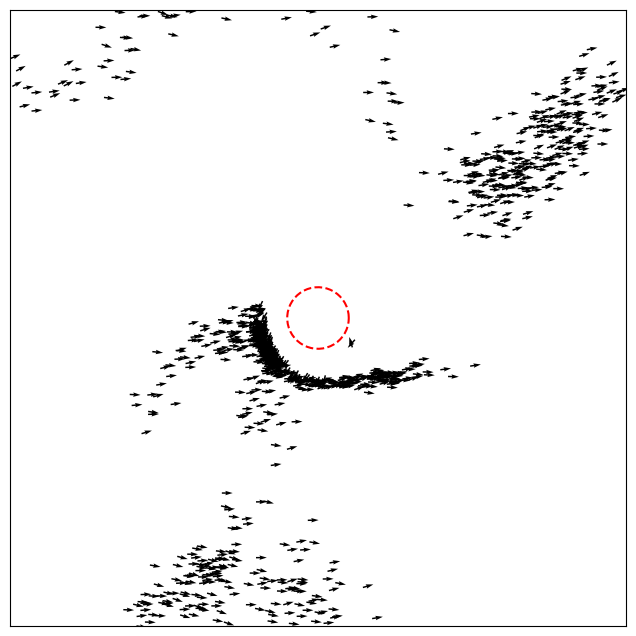

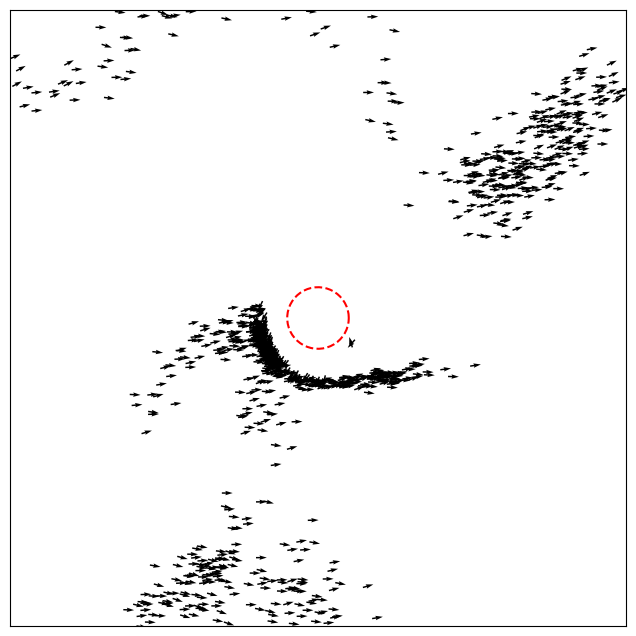

In [ ]:
# Set up a figure
fig, ax = plt.subplots(figsize = (8,8))


# Get the obstacle(s) coordinates
x_obstacle, y_obstacle = make_circular_obstacle(L//2, L//2, 0.5)

# x_obstacle, y_obstacle = make_rectangular_obstacle(L//2, L//2, 0.5, 0.5)

# Plot obstacle(s)
ax.plot(x_obstacle, y_obstacle, 'r--')


# Get the initial configuration
x, y, vx, vy, theta = initialize_birds(N, L)

# Plot initial quivers
q = plt.quiver(x,y,vx,vy)


# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Do each step, updating the quiver and plotting the new one
for i in range(Nt):
    print(i)
    x, y, vx, vy = step(x, y, vx, vy, theta, Rsq, x_obstacle, y_obstacle, eta, fov_angle, N, dt)
    q = update_quiver(q, x, y, vx, vy)
    clear_output(wait=True)
    display(fig)